# P2Ammonia Notebook

### Import libraries

In [114]:
# Import the package
import hydesign
import inspect
#Check the installation of HyDesign
print(inspect.getfile(hydesign))
from hydesign.assembly.hpp_assembly_P2Ammonia import hpp_model_P2Ammonia as hpp_model
from hydesign.Parallel_EGO import EfficientGlobalOptimizationDriver
from hydesign.examples import examples_filepath
import pandas as pd
import numpy as np
import yaml
import time
import os
import matplotlib.pyplot as plt
import sys
import shutil
import tempfile

c:\Users\Flore\Documents\GitHub\P2Ammonia_Git\hydesign\__init__.py


### Building the scenario

In [3]:
# Manually setting up the example site 
    #Path to the file containing the examples characteristics
#examples_filepath = 

In [4]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0, sep=';')

examples_sites.head(20)

,case,name,longitude,latitude,altitude,input_ts_fn,sim_pars_fn,price_fn,price_col,H2_demand_col,Unnamed: 11,input_HA_ts_fn,price_up_ts,price_dwn_ts
0,India,Indian_site_good_wind,77.500226,8.334294,679.803454,India/GWA2/input_ts_Indian_site_good_wind.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
1,India,Indian_site_good_solar,68.542204,23.542099,29.883557,India/GWA2/input_ts_Indian_site_good_solar.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
2,India,Indian_site_bad_solar_bad_wind,77.916878,17.292316,627.424643,India/GWA2/input_ts_Indian_site_bad_solar_bad_...,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
3,Europe,France_good_solar,4.229736,44.422011,204.000000,Europe/GWA2/input_ts_France_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
4,Europe,France_good_wind,-0.864258,48.744116,302.000000,Europe/GWA2/input_ts_France_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
5,Europe,France_bad_solar_n_wind,2.167969,47.428087,140.000000,Europe/GWA2/input_ts_France_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
6,Europe,Germany_bad_solar_n_wind,10.766602,49.310798,442.000000,Europe/GWA2/input_ts_Germany_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_ME,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
7,Europe,Germany_good_wind,7.873535,53.287111,5.000000,Europe/GWA2/input_ts_Germany_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_NW,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
8,Europe,Denmark_good_solar,11.813965,55.397760,42.000000,Europe/GWA2/input_ts_Denmark_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_E,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
9,Europe,Denmark_good_wind,8.594398,56.227322,85.000000,Europe/GWA2/input_ts_Denmark_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_W,Europe/H2_demand.csv,NaN,NaN,NaN,NaN


In [92]:

# Choice of case study
example = 7
input_ts_fn = examples_filepath + "Europe/GWA3/input_ts_Germany_good_wind.csv"
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0, sep=';')
ex_site = examples_sites.iloc[example]
latitude = ex_site["latitude"]
longitude = ex_site["longitude"]
altitude = ex_site["altitude"]

#Path to the yaml file
sim_pars_fn = examples_filepath + "Europe/hpp_pars.yml"
with open(sim_pars_fn) as file:
    sim_pars = yaml.load(file, Loader=yaml.FullLoader)
    
#Extra files for H2 and NH3 demand
H2_demand_fn = examples_filepath + "Europe/H2_demand.csv"
NH3_demand_fn = examples_filepath + "Europe/NH3_demand.csv"

## Evaluation

##### Choice of the design and the parameters 

In [93]:
clearance = 10
sp = 360 
p_rated = 4
Nwt = 52
wind_MW_per_km2 = 5 
    #PV plant design 
solar_MW = 239
surface_tilt = 50
surface_azimuth= 210
DC_AC_ratio = 1.5
    #Energy storage & EMS price constraints
b_P = 0
b_E_h = 0
cost_of_batt_degr = 0
    #PtG plant design
ptg_MW = 117
    #Hydrogen storage design 
HSS_kg = 0
    #Ammonia storage design 
NH3SS_kg = 16030

# Choice of H2 and NH3 prices 
price_H2 = 4 #[EUR/kg]
price_NH3  = 0.9 #[EUR/kg]

# Choice of penalties for not meeting the demand of H2 and NH3
penalty_factor_H2 = 0 #[EUR/kg]
penalty_factor_NH3 = 0.1 #[EUR/kg]

# Choice of the grid connection 
G_MW = 50 #[MW] injection  capacity on the grid

# Choice of H2 and NH3 demand 
H2_demand_hourly_value = 1000_000 # [kg/h] hourly demand of H2
NH3_demand_hourly_value = 10_000 # [kg/h] hourly demand of NH3


# Create a dictionary with variable names and their units
input_values_with_vars = {
    "clearance (m)": clearance,
    "sp (W/m²)": sp,
    "p_rated (MW)": p_rated,
    "Nwt (units)": Nwt,
    "wind_MW_per_km2 (MW/km²)": wind_MW_per_km2,
    "solar_MW (MW)": solar_MW,
    "surface_tilt (degrees)": surface_tilt,
    "surface_azimuth (degrees)": surface_azimuth,
    "DC_AC_ratio (ratio)": DC_AC_ratio,
    "b_P (MW)": b_P,
    "b_E_h (MWh)": b_E_h,
    "cost_of_batt_degr ($/kWh)": cost_of_batt_degr,
    "ptg_MW (MW)": ptg_MW,
    "HSS_kg (kg)": HSS_kg,
    "NH3SS_kg (kg)": NH3SS_kg,
    "grid connection capacity (MW)" : G_MW,
    "price of H2 (€/kg)" : price_H2, 
    "price of NH3 (€/kg)" : price_NH3,
    "H2 hourly demand (kg/h)" : H2_demand_hourly_value,
    "NH3 hourly demand (kg/h)" : NH3_demand_hourly_value,
    "penalty for NH3 unmet demand (€/kg)" : penalty_factor_NH3,
    "penalty for H2 unmet demand (€/kg)" : penalty_factor_H2,
}

# Display the input values in a formatted manner
formatted_output_with_vars = "\nModel Input Values:\n"
formatted_output_with_vars += "-" * 30 + "\n"
for key, value in input_values_with_vars.items():
    formatted_output_with_vars += f"{key}: {value}\n"

print(formatted_output_with_vars)

H2_demand_data = pd.read_csv(H2_demand_fn, header=0, index_col=0, parse_dates=True)
H2_demand_data['H2_demand'] = H2_demand_hourly_value
H2_demand_data.to_csv(H2_demand_fn)

NH3_demand_data = pd.read_csv(NH3_demand_fn, header=0, index_col=0, parse_dates=True)
NH3_demand_data['NH3_demand'] = NH3_demand_hourly_value
NH3_demand_data.to_csv(NH3_demand_fn)



Model Input Values:
------------------------------
clearance (m): 10
sp (W/m²): 360
p_rated (MW): 4
Nwt (units): 52
wind_MW_per_km2 (MW/km²): 5
solar_MW (MW): 239
surface_tilt (degrees): 50
surface_azimuth (degrees): 210
DC_AC_ratio (ratio): 1.5
b_P (MW): 0
b_E_h (MWh): 0
cost_of_batt_degr ($/kWh): 0
ptg_MW (MW): 117
HSS_kg (kg): 0
NH3SS_kg (kg): 16030
grid connection capacity (MW): 50
price of H2 (€/kg): 4
price of NH3 (€/kg): 0.9
H2 hourly demand (kg/h): 1000000
NH3 hourly demand (kg/h): 10000
penalty for NH3 unmet demand (€/kg): 0.1
penalty for H2 unmet demand (€/kg): 0



In [94]:
# Initialize the Hybrid Power Plant (HPP) model
batch_size = 15 * 24

hpp = hpp_model(
    sim_pars_fn=sim_pars_fn,  # Simulation parameters
    H2_demand_fn= H2_demand_fn, 
    NH3_demand_fn= NH3_demand_fn,
    latitude = latitude, 
    longitude = longitude, 
    altitude = altitude,  # Geographical data for the site
    input_ts_fn = input_ts_fn,
    batch_size=batch_size,
    work_dir='./',  # Directory for saving outputs
)
hpp.prob.set_val('price_H2', price_H2)
hpp.prob.set_val('price_NH3', price_NH3)
hpp.prob.set_val('G_MW', G_MW)
hpp.prob.set_val('penalty_factor_H2', penalty_factor_H2)
hpp.prob.set_val('penalty_factor_NH3', penalty_factor_NH3)

x_design = [
    # sizing variables
    clearance, sp, p_rated, Nwt, wind_MW_per_km2,
    solar_MW, surface_tilt, surface_azimuth,
    DC_AC_ratio, b_P, b_E_h, cost_of_batt_degr,
    ptg_MW, HSS_kg, NH3SS_kg
]


Fixed parameters on the site
-------------------------------
longitude = 7.873535
latitude = 53.287111
altitude = 5.0


##### Run the evaluation

In [95]:
start = time.time()
outs = hpp.evaluate(*x_design)  # Run the model evaluation
hpp.print_design(x_design, outs)

end = time.time()

print(f'Execution time [min]:', round((end - start) / 60, 2))


Design:
---------------
clearance [m]: 10.000
sp [W/m2]: 360.000
p_rated [MW]: 4.000
Nwt: 52.000
wind_MW_per_km2 [MW/km2]: 5.000
solar_MW [MW]: 239.000
surface_tilt [deg]: 50.000
surface_azimuth [deg]: 210.000
DC_AC_ratio: 1.500
b_P [MW]: 0.000
b_E_h [h]: 0.000
cost_of_battery_P_fluct_in_peak_price_ratio: 0.000
ptg_MW [MW]: 117.000
HSS_kg [kg]: 0.000
NH3SS_kg [kg]: 16030.000


NPV_over_CAPEX: 1.749
NPV [MEuro]: 927.330
IRR: 0.145
LCOE [Euro/MWh]: 30.473
LCOH [Euro/kg]: 8.932
LCONH3 [Euro/kg]: 2.196
Revenue [MEuro]: 2030.565
CAPEX [MEuro]: 530.244
OPEX [MEuro]: 22.618
penalty lifetime [MEuro]: 3.630
AEP [GWh]: 137.961
GUF: 0.315
annual_H2 [tons]: 8020.907
annual_NH3 [tons]: 48406.722
annual_Q [MW]: 36619.438
annual_P_ptg [GWh]: 674.315
grid [MW]: 50.000
wind [MW]: 208.000
solar [MW]: 239.000
PtG [MW]: 117.000
HSS [kg]: 0.000
NH3 [TDP]: 477.360
NH3SS_kg [kg]: 16030.000
Battery Energy [MWh]: 0.000
Battery Power [MW]: 0.000
Annual curtailment [GWh]: 59.608
Awpp [km2]: 41.600
Apvp [km2]: 2

##### Plot the results

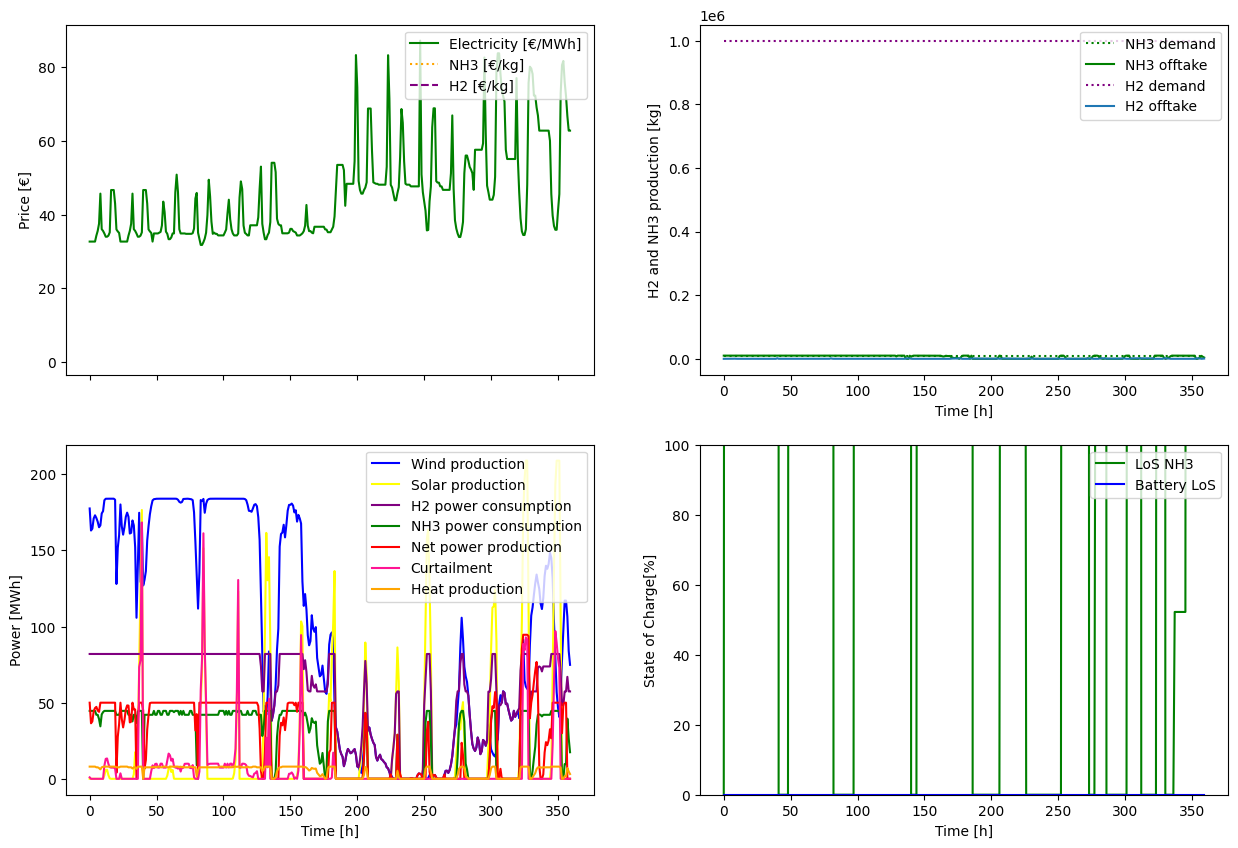

In [91]:
saving_fig_path = examples_filepath

fig = hpp.plot_P2Ammonia_results(n_hours = batch_size)

plt.show()

##### Save the timeseries output file

In [96]:
hpp.save_to_csv_results()

##### Analysis of intermittency and FLH

In [97]:
data = pd.read_excel("Results_excel.xlsx", index_col=0)

# capture price of electricity
total_revenue = (data["Price_el"] * data["hpp_t"]).sum()
total_production = data["hpp_t"].sum()
capture_price = total_revenue / total_production if total_production != 0 else 0
print(f"Capture price : {capture_price:.2f} €/MWh")

# Intermittency of electrical production
mean_export = data["hpp_t"].mean()
std_export = data["hpp_t"].std()
variability_index = std_export / mean_export if mean_export != 0 else np.nan
print(f"Variability of the grid: {variability_index:.2f}")

# Intermittency of ammonia production 
mean_nh3_power = data["m_NH3_t"].mean()
std_nh3_power = data["m_NH3_t"].std()
nh3_stability_index = std_nh3_power / mean_nh3_power if mean_nh3_power != 0 else np.nan
print(f"Stability of NH3 production : {nh3_stability_index:.2f}")

#Full load hours / demand
FLH = 0
for h in range(0,8760):
    if data["m_NH3_offtake_t"][h] == NH3_demand_hourly_value:
        FLH +=1
FLH_percent = FLH/8760
print(f"FLH_percent : {100*FLH_percent:.2f} %")
print(f"FLH : {FLH:.2f} hours")


Capture price : 39.90 €/MWh
Variability of the grid: 1.55
Stability of NH3 production : 0.99
FLH_percent : 47.12 %
FLH : 4128.00 hours


# Sizing optimization

#### Choice of optimization parameters : 

In [124]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0, sep=';')
examples_sites.head(20)

,case,name,longitude,latitude,altitude,input_ts_fn,sim_pars_fn,price_fn,price_col,H2_demand_col,Unnamed: 11,input_HA_ts_fn,price_up_ts,price_dwn_ts
0,India,Indian_site_good_wind,77.500226,8.334294,679.803454,India/GWA2/input_ts_Indian_site_good_wind.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
1,India,Indian_site_good_solar,68.542204,23.542099,29.883557,India/GWA2/input_ts_Indian_site_good_solar.csv,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
2,India,Indian_site_bad_solar_bad_wind,77.916878,17.292316,627.424643,India/GWA2/input_ts_Indian_site_bad_solar_bad_...,India/hpp_pars.yml,India/Indian_elec_price_t.csv,Price,India/H2_demand.csv,NaN,NaN,NaN,NaN
3,Europe,France_good_solar,4.229736,44.422011,204.000000,Europe/GWA2/input_ts_France_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
4,Europe,France_good_wind,-0.864258,48.744116,302.000000,Europe/GWA2/input_ts_France_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
5,Europe,France_bad_solar_n_wind,2.167969,47.428087,140.000000,Europe/GWA2/input_ts_France_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,FR_R,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
6,Europe,Germany_bad_solar_n_wind,10.766602,49.310798,442.000000,Europe/GWA2/input_ts_Germany_bad_solar_n_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_ME,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
7,Europe,Germany_good_wind,7.873535,53.287111,5.000000,Europe/GWA2/input_ts_Germany_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DE_NW,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
8,Europe,Denmark_good_solar,11.813965,55.397760,42.000000,Europe/GWA2/input_ts_Denmark_good_solar.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_E,Europe/H2_demand.csv,NaN,NaN,NaN,NaN
9,Europe,Denmark_good_wind,8.594398,56.227322,85.000000,Europe/GWA2/input_ts_Denmark_good_wind.csv,Europe/hpp_pars.yml,Europe/2030-EL_PRICE.csv,DK_W,Europe/H2_demand.csv,NaN,NaN,NaN,NaN


In [128]:
example = 4
ex_site = examples_sites.iloc[example]
input_ts_fn = examples_filepath + str(ex_site['input_ts_fn'])
sim_pars_fn = examples_filepath + "Europe/hpp_pars.yml"
print(input_ts_fn)

# Choice of H2 and NH3 prices 
price_H2 = 4 #[EUR/kg]
price_NH3  = 0.9 #[EUR/kg]

# Choice of penalties for not meeting the demand of H2 and NH3
penalty_factor_H2 = 0 #[EUR/kg]
penalty_factor_NH3 = 0.1 #[EUR/kg]

# Choice of the grid connection 
G_MW = 50 #[MW] injection  capacity on the grid

# Choice of H2 and NH3 demand 
H2_demand_hourly_value = 1000_000 # [kg/h] hourly demand of H2
NH3_demand_hourly_value = 10_000 # [kg/h] hourly demand of NH3

# Create a dictionary with variable names and their units
parameters_for_sizing = {
    "grid connection capacity (MW)" : G_MW,
    "price of H2 (€/kg)" : price_H2, 
    "price of NH3 (€/kg)" : price_NH3,
    "H2 hourly demand (kg/h)" : H2_demand_hourly_value,
    "NH3 hourly demand (kg/h)" : NH3_demand_hourly_value,
    "penalty for NH3 unmet demand (€/kg)" : penalty_factor_NH3,
    "penalty for H2 unmet demand (€/kg)" : penalty_factor_H2,
}

# Display the input values in a formatted manner
formatted_output_parameters_sizing = "\nOptimal sizing Input Values:\n"
formatted_output_parameters_sizing += "-" * 30 + "\n"
for key, value in parameters_for_sizing.items():
    formatted_output_parameters_sizing += f"{key}: {value}\n"

print(formatted_output_parameters_sizing)

c:/Users/Flore/Documents/GitHub/P2Ammonia_Git/hydesign/examples/Europe/GWA2/input_ts_France_good_wind.csv

Optimal sizing Input Values:
------------------------------
grid connection capacity (MW): 50
price of H2 (€/kg): 4
price of NH3 (€/kg): 0.9
H2 hourly demand (kg/h): 1000000
NH3 hourly demand (kg/h): 10000
penalty for NH3 unmet demand (€/kg): 0.1
penalty for H2 unmet demand (€/kg): 0



##### Updating the scenario with parameters

In [129]:
H2_demand_data = pd.read_csv(H2_demand_fn, header=0, index_col=0, parse_dates=True)
H2_demand_data['H2_demand'] = H2_demand_hourly_value
H2_demand_data.to_csv(H2_demand_fn)

NH3_demand_data = pd.read_csv(NH3_demand_fn, header=0, index_col=0, parse_dates=True)
NH3_demand_data['NH3_demand'] = NH3_demand_hourly_value
NH3_demand_data.to_csv(NH3_demand_fn)

print("H2 and NH3 demand modified")

# Original YAML file
sim_pars_copy_fn = examples_filepath + "Europe/hpp_pars_copy_temp.yml"
#Copy of the YAML file
shutil.copy2(sim_pars_fn, sim_pars_copy_fn)

with open(sim_pars_copy_fn, "r", encoding="utf-8") as file: 
    sim_pars_copy = yaml.safe_load(file)

sim_pars_copy['G_MW'] = G_MW
sim_pars_copy['price_H2'] = price_H2
sim_pars_copy['price_NH3'] = price_NH3
sim_pars_copy['penalty_factor_H2'] = penalty_factor_H2
sim_pars_copy['penalty_factor_NH3'] = penalty_factor_NH3

with open(sim_pars_copy_fn, "w", encoding ='utf-8') as file:
    yaml.dump(sim_pars_copy, file, default_flow_style=False, allow_unicode=True)
print("YAML file up to date")
print(yaml.dump(sim_pars_copy))

H2 and NH3 demand modified
YAML file up to date
AEC_capex_cost: 825
AEC_opex_cost: 35
ASU_capex_cost: 27000
G_MW: 50
H2_storage_capex_cost: 300
H2_storage_eff: 0.9
H2_storage_opex_cost: 3
H2_transportation_cost: 5
H2_transportation_distance: 0
HP_SOEC_add_costs: -700
HP_SOEC_add_power: 0
HP_SOEC_capex_cost: 930
HP_SOEC_opex_cost: 110
HTP_AEC_add_costs: -200
HTP_AEC_add_power: 0
HTP_AEC_capex_cost: 775
HTP_AEC_opex_cost: 93
LP_SOEC_add_costs: -578
LP_SOEC_add_power: 0.244
LP_SOEC_capex_cost: 775
LP_SOEC_opex_cost: 93
LTP_AEC_add_costs: 0
LTP_AEC_add_power: 0
LTP_AEC_capex_cost: 550
LTP_AEC_opex_cost: 11
NH3_HB_capex_cost: 300000
NH3_HB_opex_cost: 9000
NH3_WACC: 0.08
NH3_storage_capex_cost: 800
NH3_storage_eff: 0.99
N_life: 25
PEM_add_costs: 4
PEM_add_power: 0.079
PEM_capex_cost: 650
PEM_opex_cost: 13
P_elec_N2_kg: 0.25
P_elec_NH3_kg: 4
altitude: null
battery_BOP_installation_commissioning_cost: 80000
battery_WACC: 0.06
battery_charge_efficiency: 0.985
battery_control_system_cost: 2250
b

In [130]:
inputs = {
        'name': ex_site['name'],
        'longitude': ex_site['longitude'],
        'latitude': ex_site['latitude'],
        'altitude': ex_site['altitude'],
        'input_ts_fn': input_ts_fn,
        'sim_pars_fn': sim_pars_copy_fn,
        'H2_demand_fn': H2_demand_fn,
        'NH3_demand_fn': NH3_demand_fn,
        'price_col': ex_site['price_col'],

        'opt_var': "NPV_over_CAPEX",
        'num_batteries': 10,
        'n_procs': 4,
        'n_doe': 40,
        'n_clusters': 4,
        'n_seed': 0,
        'max_iter': 20,
        'final_design_fn': 'hydesign_design_P2Ammonia.csv',
        'npred': 3e4,
        'tol': 1e-6,
        'min_conv_iter': 2,
        'work_dir': './',
        'hpp_model': hpp_model,
    'variables': {
        'clearance [m]':
            # {'var_type':'design',
            #   'limits':[10, 60],
            #   'types':'int'
            #   },
            {'var_type':'fixed',
              'value': 10
              },
         'sp [W/m2]':
            # {'var_type':'design',
            #  'limits':[200, 360],
            #  'types':'int'  
            #  },
            {'var_type':'fixed',
              'value': 360
              },
        'p_rated [MW]':
            # {'var_type':'design',
            #   'limits':[1, 10],
            #   'types':'int'
            #   },
            {'var_type':'fixed',
             'value': 4
             },
        'Nwt':
            {'var_type':'design',
             'limits':[10, 100],
             'types':'int'
              },
            # {'var_type':'fixed',
            #  'value': 60
            #  },
        'wind_MW_per_km2 [MW/km2]':
            # {'var_type':'design',
            #   'limits':[5, 9],
            #   'types':'float'
            #   },
            {'var_type':'fixed',
              'value': 5
              },
        'solar_MW [MW]':
            {'var_type':'design',
              'limits':[0, 400],
             'types':'int'
              },
            # {'var_type':'fixed',
            #  'value': 80
            # },
        'surface_tilt [deg]':
            # {'var_type':'design',
            #   'limits':[0, 50],
            #   'types':'float'
            #   },
            {'var_type':'fixed',
              'value': 50
              },
        'surface_azimuth [deg]':
            # {'var_type':'design',
            #   'limits':[150, 210],
            #   'types':'float'
            #   },
            {'var_type':'fixed',
              'value': 210
              },
        'DC_AC_ratio':
            # {'var_type':'design',
            #   'limits':[1, 2.0],
            #   'types':'float'
            #   },
            {'var_type':'fixed',
              'value':1.5,
              },
        'b_P [MW]':
            # {'var_type':'design',
            #   'limits':[0, 200],
            #   'types':'int'
            #   },
            {'var_type':'fixed',
             'value': 0
            },
        'b_E_h [h]':
            {'var_type':'design',
              'limits':[0,20],
              'types':'int'
              },
            #{'var_type':'fixed',
            #  'value': 3
            #  },
        'cost_of_battery_P_fluct_in_peak_price_ratio':
            # {'var_type':'design',
            #   'limits':[0, 20],
            #   'types':'float'
            #   },
            {'var_type':'fixed',
              'value': 0},
        'ptg_MW [MW]':
            {'var_type':'design',
              'limits':[0, 200],
              'types':'int'
              },
            # {'var_type':'fixed',
            #  'value': 150
            # }, 
        'HSS_kg [kg]':
            {'var_type':'design',
              'limits':[0, 10_000],
              'types':'int'
             },
            # {'var_type':'fixed',
            #  'value': 0
            # },
        'NH3SS_kg [kg]':
            {'var_type':'design',
              'limits':[0, 30_000],
              'types':'int'
              },
            #{'var_type':'fixed',
            # 'value': 0
            # },
        }}

##### Run the sizing

In [ ]:
EGOD = EfficientGlobalOptimizationDriver(**inputs)
EGOD.run()
result = EGOD.result





Sizing a HPP plant at France_good_wind:


Fixed parameters on the site
-------------------------------
longitude = -0.864258
latitude = 48.744116
altitude = 302.0





In [123]:
os.remove(sim_pars_copy_fn)
print('YAML copy deleted')

YAML copy deleted
